In [2]:
!pip install tqdm boto3 requests regex sentencepiece sacremoses datasets

In [4]:
import torch
from torchinfo import summary
from datasets import load_dataset
from torch.utils.data import DataLoader
import transformers
from transformers import DistilBertTokenizer, DistilBertConfig, DistilBertModel

# DistilBERT 모델용 tokenizer 로드 (pretrained)
# 이 tokenizer는 문장을 토큰화해서 모델이 이해할 수 있는 input_ids로 변환해줌
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [6]:
# 데이터셋 다운로드
import kagglehub

file_path = "thedevastator/unlocking-language-understanding-with-the-multin"

path = kagglehub.dataset_download(file_path)
print("file path", path)

file path /Users/seungchanhong/.cache/kagglehub/datasets/thedevastator/unlocking-language-understanding-with-the-multin/versions/2


In [8]:
import random
import pandas as pd

# 데이터 불러오는 함수
def load_data(path, nrows=None):
    # pandas로 csv 파일 읽기
    df = pd.read_csv(path, nrows=nrows, keep_default_na=False)
    data = []
    for _, row in df.iterrows():
        # premise 열, hypothesis 열 모두 0이 아닐 때
        if len(row['premise']) * len(row['hypothesis']) != 0:
            data.append({'premise': row['premise'], 'hypothesis': row['hypothesis'], 'label': row['label']})

    return data

# train data, test data 각각 1,000줄씩 가져오기
train_ds = load_data(path + '/train.csv', nrows=1000)
test_ds = load_data(path + '/validation_matched.csv', nrows=1000)

In [10]:
# 데이터 형태 및 결측치 확인하기

print("train data sample", train_ds[0])
df_train, df_test = pd.DataFrame(train_ds), pd.DataFrame(test_ds)
print("=" * 80)
print("train data", df_train)
print("test data", df_test)
print(df_train.isnull().sum(), df_test.isnull().sum())

train data sample {'premise': 'Conceptually cream skimming has two basic dimensions - product and geography.', 'hypothesis': 'Product and geography are what make cream skimming work. ', 'label': 1}
train data                                                premise  \
0    Conceptually cream skimming has two basic dime...   
1    you know during the season and i guess at at y...   
2    One of our number will carry out your instruct...   
3    How do you know? All this is their information...   
4    yeah i tell you what though if you go price so...   
..                                                 ...   
995  so let's see what well what kind of music do y...   
996  They--hey, what's that?"  He was looking up, a...   
997  Or does cold iron ruin your conjuring here?  S...   
998  5 million Americans living in households with ...   
999  These Year 2000 conversion efforts are often c...   

                                            hypothesis  label  
0    Product and geography are

* 결측치는 없는 것으로 확인됨

In [123]:
# collate_fn 정의
def collate_fn(batch):
    max_len = 400  # 입력 문장의 최대 길이 설정
    # 문장 1 : premises / 문장 2 : hypotheses / labels를 저장할 리스트
    premises, hypotheses, labels = [], [], []  

    # 배치 내 각 샘플에 대해 text와 label 추출 : text는 'premise', label은 '
    for row in batch:
        premises.append(row['premise'])
        hypotheses.append(row['hypothesis'])
        labels.append(row['label'])

    # tokenizer로 두 문장을 토큰화 : truncation=True로 수정
    encoded = tokenizer(
        premises, hypotheses, padding=True, truncation=True, max_length=max_len, return_tensors='pt'
    )
    
    input_ids = encoded['input_ids']
    attention_mask = encoded['attention_mask']

    # 라벨 리스트를 LongTensor로 변환
    labels = torch.LongTensor(labels)

    # 모델 학습에 필요한 입력 (토큰화된 문장들)과 정답 라벨 반환
    return input_ids, attention_mask, labels

# 학습용 DataLoader 정의 (shuffle=True로 배치 순서 랜덤화)
train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)

# 테스트용 DataLoader 정의 (shuffle=False로 배치 순서 고정)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

In [125]:
# 모델 가져오기
config = DistilBertConfig()
model = DistilBertModel(config)
print(model)
print(summary(model))

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [126]:
from torch import nn

# 문장 분류 모델 정의 (DistilBERT + Linear layer)
class SentenceClassifier(nn.Module):
    def __init__(self, num_labels=3):
        super().__init__()

        # 사전학습된 DistilBERT 모델을 encoder로 사용 (pretrained transformer)
        self.encoder = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # [CLS] 토큰 분류기 정의
        self.classifier = nn.Linear(768, 3) # label의 분류가 3개이므로 출력 차원 수정

    def forward(self, input_ids, attention_mask=None):
        # encoder에 input_ids 전달
        x = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        x = x.last_hidden_state[:, 0]
        # [CLS] 토큰 위치 벡터를 classification head에 전달
        x = self.classifier(x)

        return x  # logit 출력

model = SentenceClassifier()

In [129]:
device = torch.device("cpu")

# device = torch.device("mps") 사용시 Error
- RuntimeError: Placeholder storage has not been allocated on MPS device!
- huggingface model이 내부에서 GPU를 사용하여 연산을 시도하면 MPS가 embedding layerdml weight 초기화 방식을 지원하지 못해서 생기는 오류

In [131]:
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt

* (1) lr=0.001, 10 Epochs, freeze한 경우 
Epoch   1 | Train Loss: 17.8626  
Epoch   2 | Train Loss: 17.3871  
Epoch   3 | Train Loss: 17.0859  
Epoch   4 | Train Loss: 16.9338  
Epoch   5 | Train Loss: 16.6029  
Epoch   6 | Train Loss: 16.6217  
Epoch   7 | Train Loss: 16.4395  
Epoch   8 | Train Loss: 16.2315  
Epoch   9 | Train Loss: 16.1731  
Epoch  10 | Train Loss: 16.0244

* (2) lr=0.001, 10 Epochs, freeze 안 한 경우
Epoch   1 | Train Loss: 20.1358  
Epoch   2 | Train Loss: 17.6525  
Epoch   3 | Train Loss: 17.7309  
Epoch   4 | Train Loss: 17.5264  
Epoch   5 | Train Loss: 17.5647  
Epoch   6 | Train Loss: 17.5760  
Epoch   7 | Train Loss: 18.1225  
Epoch   8 | Train Loss: 17.5020  
Epoch   9 | Train Loss: 17.5298  
Epoch  10 | Train Loss: 17.5627

* (3) lr=2e-5, 10 Epochs, freeze한 경우  
Epoch   1 | Train Loss: 18.0912  
Epoch   2 | Train Loss: 17.9103  
Epoch   3 | Train Loss: 17.9020  
Epoch   4 | Train Loss: 17.7240  
Epoch   5 | Train Loss: 17.6628  
Epoch   6 | Train Loss: 17.5195  
Epoch   7 | Train Loss: 17.5277  
Epoch   8 | Train Loss: 17.5452  
Epoch   9 | Train Loss: 17.5176  
Epoch  10 | Train Loss: 17.3895

* (4) lr=2e-5, 10 Epochs, freeze 안 한 경우
Epoch   1 | Train Loss: 17.5074  
Epoch   2 | Train Loss: 16.6619  
Epoch   3 | Train Loss: 14.7587  
Epoch   4 | Train Loss: 11.9689  
Epoch   5 | Train Loss: 8.6955  
Epoch   6 | Train Loss: 5.3961  
Epoch   7 | Train Loss: 2.7642  
Epoch   8 | Train Loss: 1.2298  
Epoch   9 | Train Loss: 0.5643  
Epoch  10 | Train Loss: 0.2845  

* (5) lr=2e-5, 20 Epochs, freeze 안 한 경우  
Epoch   1 | Train Loss: 17.3238  
Epoch   2 | Train Loss: 16.4781  
Epoch   3 | Train Loss: 14.0642  
Epoch   4 | Train Loss: 11.1895  
Epoch   5 | Train Loss: 8.0073  
Epoch   6 | Train Loss: 5.3074  
Epoch   7 | Train Loss: 2.9897  
Epoch   8 | Train Loss: 1.6101  
Epoch   9 | Train Loss: 0.8808  
Epoch  10 | Train Loss: 0.4384  
Epoch  11 | Train Loss: 0.2397  
Epoch  12 | Train Loss: 0.2007  
Epoch  13 | Train Loss: 0.1336  
Epoch  14 | Train Loss: 0.1322  
Epoch  15 | Train Loss: 0.0939  
Epoch  16 | Train Loss: 0.0761  
Epoch  17 | Train Loss: 0.0581  
Epoch  18 | Train Loss: 0.0504  
Epoch  19 | Train Loss: 0.0514  
Epoch  20 | Train Loss: 0.0431  

In [146]:
# 정확도 측정하는 함수
def accuracy(model, dataloader):
    cnt = 0      # 전체 샘플 수
    acc = 0      # 정답 개수 누적

    for data in dataloader:
        input_ids, attention_mask, labels = data
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, attention_mask=attention_mask)  # (batch_size, num_classes = 3)
        # print(outputs.shape)
        outputs = torch.argmax(outputs, dim=-1) # 출력 차원 조정

        cnt += labels.size(0)  # 총 샘플 수 누적
        acc += (labels == outputs).sum().item()  # 예측이 맞은 수 누적

    return acc / cnt  # 정확도 반환

* (1) lr=0.001, 10 Epochs, freeze  
Train acc: 0.533 | Test acc: 0.404

* (2) lr=0.001, 10 Epochs, freeze X  
Train acc: 0.375 | Test acc: 0.340

* (3) lr=2e-5, 10 Epochs, freeze  
Train acc: 0.392 | Test acc: 0.355

* (4) lr=2e-5, 10 Epochs, freeze X  
Train acc: 1.000 | Test acc: 0.589

* (5) lr=2e-5, 20 Epochs, freeze X  
Train acc: 1.000 | Test acc: 0.568

In [149]:
# plot 그리는 함수
def plot_metrics(losses, train_accs, test_accs, title='Training Metrics'):
    epochs = list(range(1, len(losses) + 1))
    
    plt.figure(figsize=(12, 4))

    # Train Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, marker='o', label='Train Loss')
    plt.title('Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Train Accuracy, Test Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, marker='o', label='Train Acc')
    plt.plot(epochs, test_accs, marker='x', label='Test Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [151]:
from torch.optim import Adam

def model_experiments(lr, epochs, freeze, device):
    print(f"\n▶ Running: lr={lr}, freeze={freeze}, epochs={epochs}")

    model = SentenceClassifier().to(device)

    for param in model.encoder.parameters():
        param.requires_grad = not freeze

    optimizer = Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    losses = []
    train_accs = []
    test_accs = []

    for epoch in range(epochs):
        total_loss = 0.
        model.train()

        for data in train_loader:
            model.zero_grad()

            input_ids, attention_mask, labels = data
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, attention_mask=attention_mask) # (batch_size, num_classes = 3)
            # print(outputs.shape)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        losses.append(total_loss)

        # 평가 시 gradient 계산 비활성화
        with torch.no_grad():
            model.eval() # 평가 모드로 전환 (계산 비활성화)
            train_acc = accuracy(model, train_loader)
            test_acc = accuracy(model, test_loader)

        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1:3d} | Train Loss {total_loss:.4f} | Train Acc: {train_acc:.3f} | Test Acc: {test_acc:.3f}')

    plot_metrics(
        losses, train_accs, test_accs,
        title=f"LR={lr} | Freeze={freeze} | Epochs={epochs}"
    )

    return {
        'lr': lr,
        'freeze': freeze,
        'epochs': epochs,
        'train_acc': train_accs[-1],
        'test_acc': test_accs[-1],
        'losses': losses,
        'train_accs': train_accs,
        'test_accs': test_accs,
    }


▶ Running: lr=0.001, freeze=True, epochs=10
Epoch   1 | Train Loss 17.5514 | Train Acc: 0.439 | Test Acc: 0.354
Epoch   2 | Train Loss 17.3018 | Train Acc: 0.425 | Test Acc: 0.360
Epoch   3 | Train Loss 16.8977 | Train Acc: 0.472 | Test Acc: 0.378
Epoch   4 | Train Loss 16.7384 | Train Acc: 0.496 | Test Acc: 0.392
Epoch   5 | Train Loss 16.5985 | Train Acc: 0.494 | Test Acc: 0.388
Epoch   6 | Train Loss 16.4616 | Train Acc: 0.500 | Test Acc: 0.384
Epoch   7 | Train Loss 16.3448 | Train Acc: 0.515 | Test Acc: 0.383
Epoch   8 | Train Loss 16.2430 | Train Acc: 0.491 | Test Acc: 0.392
Epoch   9 | Train Loss 15.9991 | Train Acc: 0.536 | Test Acc: 0.409
Epoch  10 | Train Loss 16.0251 | Train Acc: 0.541 | Test Acc: 0.391


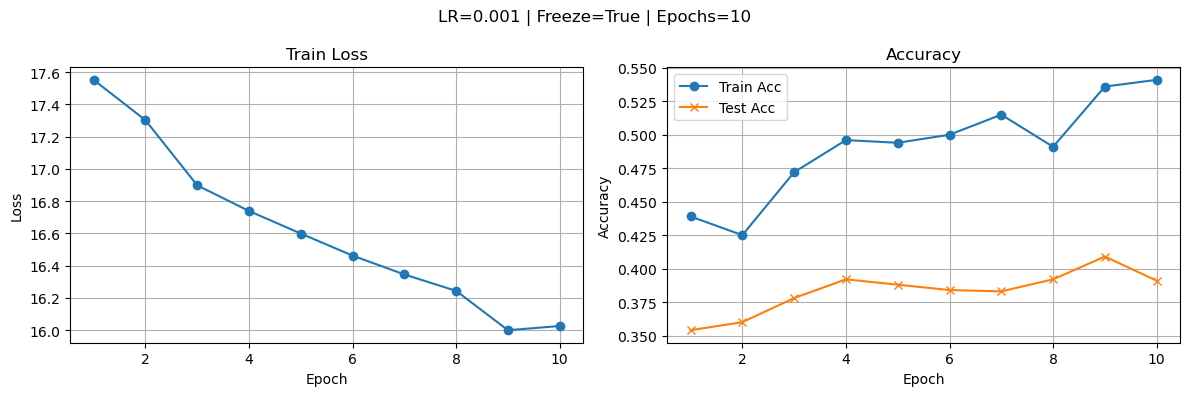


▶ Running: lr=0.001, freeze=True, epochs=20
Epoch   1 | Train Loss 17.4157 | Train Acc: 0.387 | Test Acc: 0.338
Epoch   2 | Train Loss 17.1862 | Train Acc: 0.446 | Test Acc: 0.349
Epoch   3 | Train Loss 16.9835 | Train Acc: 0.474 | Test Acc: 0.364
Epoch   4 | Train Loss 16.7759 | Train Acc: 0.489 | Test Acc: 0.373
Epoch   5 | Train Loss 16.5264 | Train Acc: 0.501 | Test Acc: 0.388
Epoch   6 | Train Loss 16.4458 | Train Acc: 0.513 | Test Acc: 0.391
Epoch   7 | Train Loss 16.3291 | Train Acc: 0.500 | Test Acc: 0.392
Epoch   8 | Train Loss 16.2514 | Train Acc: 0.528 | Test Acc: 0.394
Epoch   9 | Train Loss 16.0643 | Train Acc: 0.503 | Test Acc: 0.386
Epoch  10 | Train Loss 16.0192 | Train Acc: 0.551 | Test Acc: 0.402
Epoch  11 | Train Loss 15.9288 | Train Acc: 0.547 | Test Acc: 0.393
Epoch  12 | Train Loss 15.7777 | Train Acc: 0.552 | Test Acc: 0.395
Epoch  13 | Train Loss 15.7878 | Train Acc: 0.567 | Test Acc: 0.398
Epoch  14 | Train Loss 15.6623 | Train Acc: 0.561 | Test Acc: 0.395
Epo

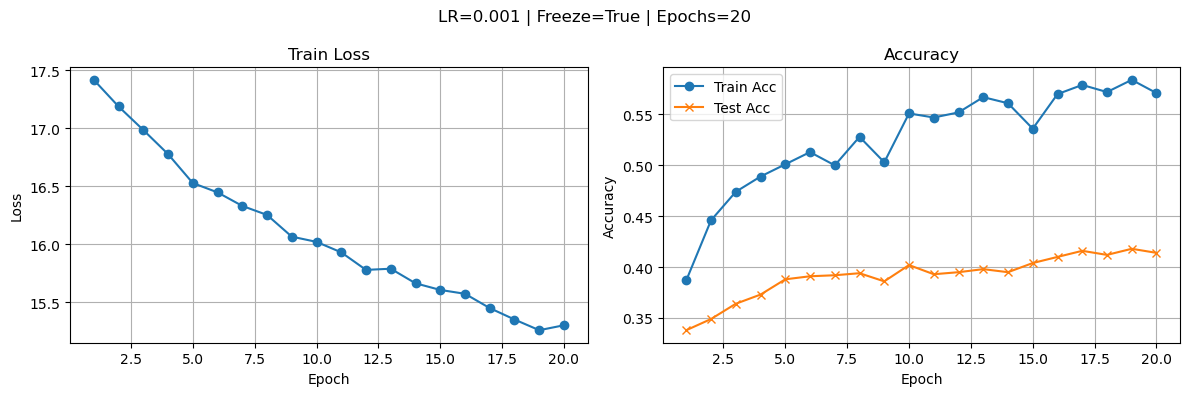


▶ Running: lr=0.001, freeze=False, epochs=10
Epoch   1 | Train Loss 19.4326 | Train Acc: 0.343 | Test Acc: 0.341
Epoch   2 | Train Loss 18.9641 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   3 | Train Loss 17.5593 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   4 | Train Loss 17.5544 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   5 | Train Loss 17.5158 | Train Acc: 0.343 | Test Acc: 0.341
Epoch   6 | Train Loss 17.5964 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   7 | Train Loss 17.6026 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   8 | Train Loss 17.9714 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   9 | Train Loss 17.6214 | Train Acc: 0.343 | Test Acc: 0.341
Epoch  10 | Train Loss 17.5818 | Train Acc: 0.375 | Test Acc: 0.340


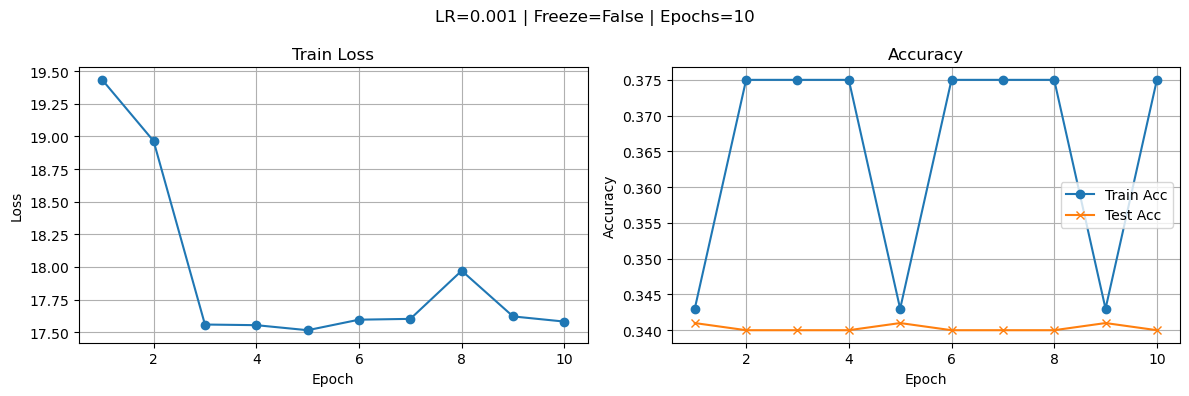


▶ Running: lr=0.001, freeze=False, epochs=20
Epoch   1 | Train Loss 24.4104 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   2 | Train Loss 17.7618 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   3 | Train Loss 17.8210 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   4 | Train Loss 17.5655 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   5 | Train Loss 17.5383 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   6 | Train Loss 17.6269 | Train Acc: 0.282 | Test Acc: 0.319
Epoch   7 | Train Loss 17.6892 | Train Acc: 0.375 | Test Acc: 0.340
Epoch   8 | Train Loss 18.9885 | Train Acc: 0.282 | Test Acc: 0.319
Epoch   9 | Train Loss 17.5597 | Train Acc: 0.343 | Test Acc: 0.341
Epoch  10 | Train Loss 17.5837 | Train Acc: 0.379 | Test Acc: 0.341
Epoch  11 | Train Loss 17.6389 | Train Acc: 0.378 | Test Acc: 0.337
Epoch  12 | Train Loss 17.8162 | Train Acc: 0.375 | Test Acc: 0.340
Epoch  13 | Train Loss 17.7144 | Train Acc: 0.375 | Test Acc: 0.340
Epoch  14 | Train Loss 17.5631 | Train Acc: 0.343 | Test Acc: 0.341
Ep

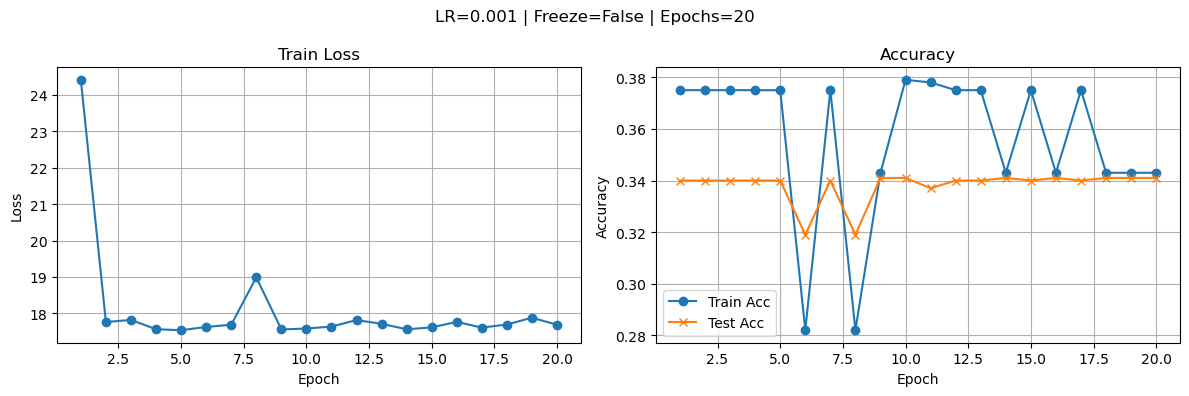


▶ Running: lr=2e-05, freeze=True, epochs=10
Epoch   1 | Train Loss 17.8959 | Train Acc: 0.376 | Test Acc: 0.340
Epoch   2 | Train Loss 17.8081 | Train Acc: 0.375 | Test Acc: 0.339
Epoch   3 | Train Loss 17.6842 | Train Acc: 0.374 | Test Acc: 0.339
Epoch   4 | Train Loss 17.7207 | Train Acc: 0.377 | Test Acc: 0.338
Epoch   5 | Train Loss 17.6135 | Train Acc: 0.378 | Test Acc: 0.338
Epoch   6 | Train Loss 17.5572 | Train Acc: 0.377 | Test Acc: 0.337
Epoch   7 | Train Loss 17.5556 | Train Acc: 0.379 | Test Acc: 0.336
Epoch   8 | Train Loss 17.4882 | Train Acc: 0.382 | Test Acc: 0.338
Epoch   9 | Train Loss 17.4897 | Train Acc: 0.381 | Test Acc: 0.339
Epoch  10 | Train Loss 17.4562 | Train Acc: 0.385 | Test Acc: 0.338


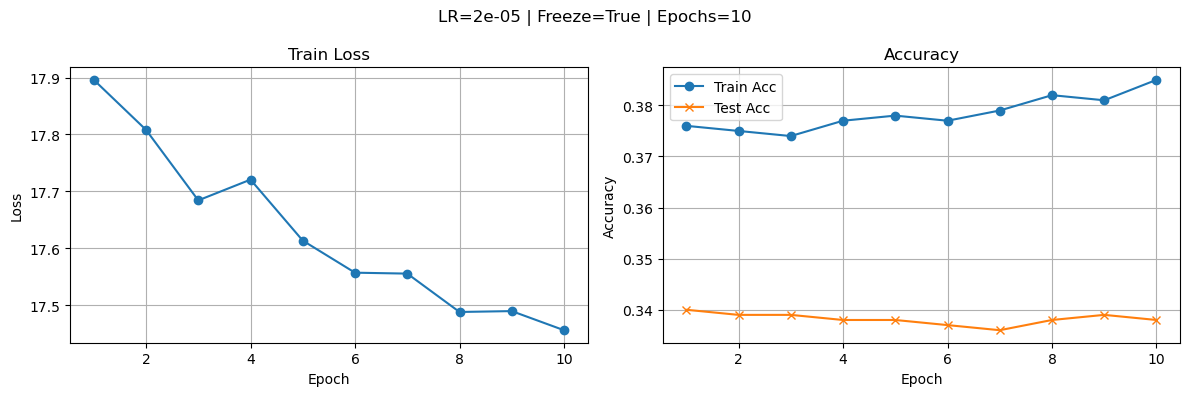


▶ Running: lr=2e-05, freeze=True, epochs=20
Epoch   1 | Train Loss 17.7594 | Train Acc: 0.299 | Test Acc: 0.316
Epoch   2 | Train Loss 17.7134 | Train Acc: 0.305 | Test Acc: 0.331
Epoch   3 | Train Loss 17.6247 | Train Acc: 0.305 | Test Acc: 0.338
Epoch   4 | Train Loss 17.6231 | Train Acc: 0.318 | Test Acc: 0.333
Epoch   5 | Train Loss 17.5654 | Train Acc: 0.334 | Test Acc: 0.343
Epoch   6 | Train Loss 17.5872 | Train Acc: 0.352 | Test Acc: 0.336
Epoch   7 | Train Loss 17.5893 | Train Acc: 0.355 | Test Acc: 0.330
Epoch   8 | Train Loss 17.4679 | Train Acc: 0.361 | Test Acc: 0.338
Epoch   9 | Train Loss 17.4947 | Train Acc: 0.368 | Test Acc: 0.345
Epoch  10 | Train Loss 17.5675 | Train Acc: 0.372 | Test Acc: 0.345
Epoch  11 | Train Loss 17.5076 | Train Acc: 0.369 | Test Acc: 0.348
Epoch  12 | Train Loss 17.4622 | Train Acc: 0.378 | Test Acc: 0.345
Epoch  13 | Train Loss 17.4379 | Train Acc: 0.378 | Test Acc: 0.343
Epoch  14 | Train Loss 17.4673 | Train Acc: 0.387 | Test Acc: 0.335
Epo

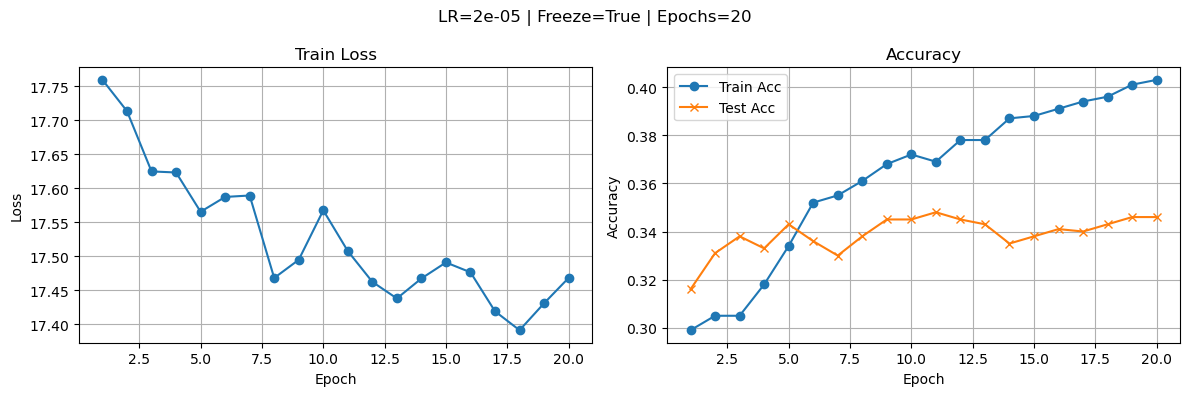


▶ Running: lr=2e-05, freeze=False, epochs=10
Epoch   1 | Train Loss 17.4938 | Train Acc: 0.396 | Test Acc: 0.344
Epoch   2 | Train Loss 17.0527 | Train Acc: 0.524 | Test Acc: 0.370
Epoch   3 | Train Loss 15.6305 | Train Acc: 0.696 | Test Acc: 0.441
Epoch   4 | Train Loss 12.6570 | Train Acc: 0.798 | Test Acc: 0.506
Epoch   5 | Train Loss 9.4617 | Train Acc: 0.876 | Test Acc: 0.517
Epoch   6 | Train Loss 5.9010 | Train Acc: 0.975 | Test Acc: 0.527
Epoch   7 | Train Loss 3.4200 | Train Acc: 0.991 | Test Acc: 0.533
Epoch   8 | Train Loss 1.7961 | Train Acc: 1.000 | Test Acc: 0.538
Epoch   9 | Train Loss 0.7821 | Train Acc: 1.000 | Test Acc: 0.542
Epoch  10 | Train Loss 0.4234 | Train Acc: 1.000 | Test Acc: 0.539


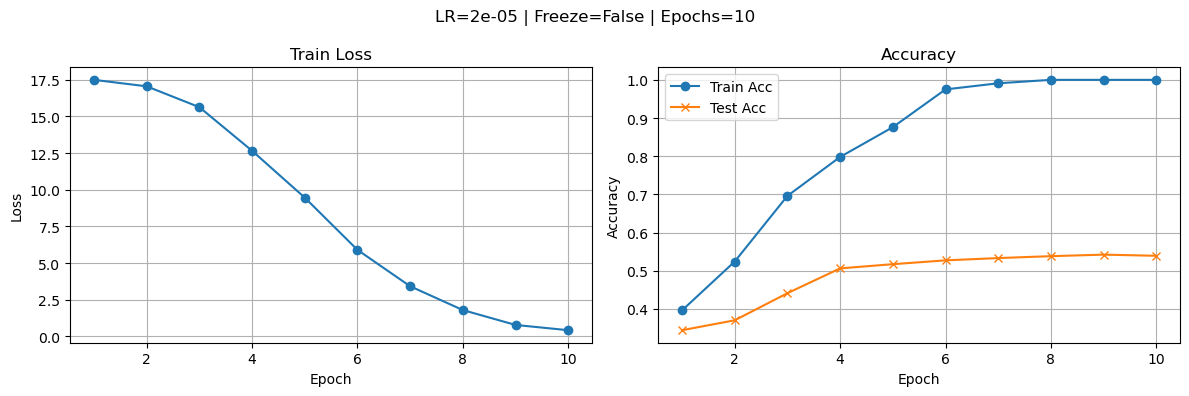


▶ Running: lr=2e-05, freeze=False, epochs=20
Epoch   1 | Train Loss 17.7698 | Train Acc: 0.450 | Test Acc: 0.371
Epoch   2 | Train Loss 16.9363 | Train Acc: 0.562 | Test Acc: 0.390
Epoch   3 | Train Loss 15.5572 | Train Acc: 0.684 | Test Acc: 0.460
Epoch   4 | Train Loss 12.6697 | Train Acc: 0.793 | Test Acc: 0.522
Epoch   5 | Train Loss 9.4712 | Train Acc: 0.912 | Test Acc: 0.542
Epoch   6 | Train Loss 5.9763 | Train Acc: 0.959 | Test Acc: 0.558
Epoch   7 | Train Loss 3.5982 | Train Acc: 0.993 | Test Acc: 0.565
Epoch   8 | Train Loss 1.8799 | Train Acc: 0.999 | Test Acc: 0.568
Epoch   9 | Train Loss 0.9102 | Train Acc: 0.999 | Test Acc: 0.572
Epoch  10 | Train Loss 0.4477 | Train Acc: 0.999 | Test Acc: 0.584
Epoch  11 | Train Loss 0.3140 | Train Acc: 1.000 | Test Acc: 0.564
Epoch  12 | Train Loss 0.1970 | Train Acc: 1.000 | Test Acc: 0.569
Epoch  13 | Train Loss 0.1531 | Train Acc: 1.000 | Test Acc: 0.562
Epoch  14 | Train Loss 0.0985 | Train Acc: 1.000 | Test Acc: 0.556
Epoch  15 | 

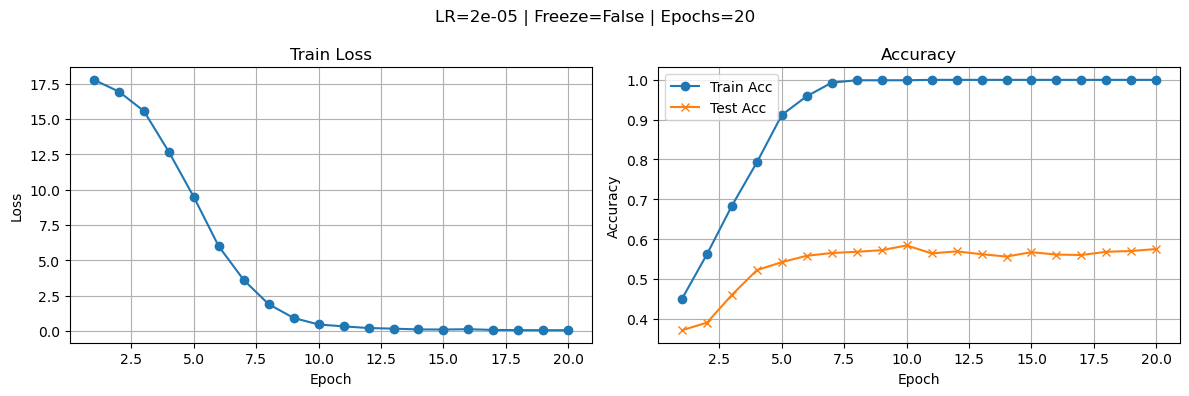

In [153]:
results = []

for lr in [0.001, 2e-5]:
    for freeze in [True, False]:
        for epochs in [10, 20]:
            result = model_experiments(lr, epochs, freeze, device)
            results.append(result)